<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

In [1]:
#установка и проверка наличия обновлений библиотек
!pip install phik
!pip install lightgbm
!pip install statsmodels

In [2]:
# импорт библиотек
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.tsa.seasonal import seasonal_decompose
import phik
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error as mse

In [3]:
#задание стиля диаграмм
mpl.style.use(['Solarize_Light2'])

## Подготовка

Загружаю и осматриваю предоставленный датасет.

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Есть два столбца: с датой и временем и с колличеством заказов. Пропущенные значения отсутствуют. Теперь необходимо ресемплировать его по одному часу.

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Я успешно ресемплировала датасет, объединив данные о колличестве заказов по часам.

## Анализ

Модель, которую я построю, должна будет предсказывать колличество заказов такси из аэропорта на следующий час. Я уже сгруппировала данные о колличестве заказов по часам, и теперь могу при помощи нескольких графиков проанализировать, в какое время и в какие дни заказы происходят чаще всего.

Посмотрим, с какой по какую дату имеется информация.

In [6]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


Мне доступны данные с первого марта по 31 августа 2018 года. Для начала построю графики сезонности, сгруппировав данные по дням.

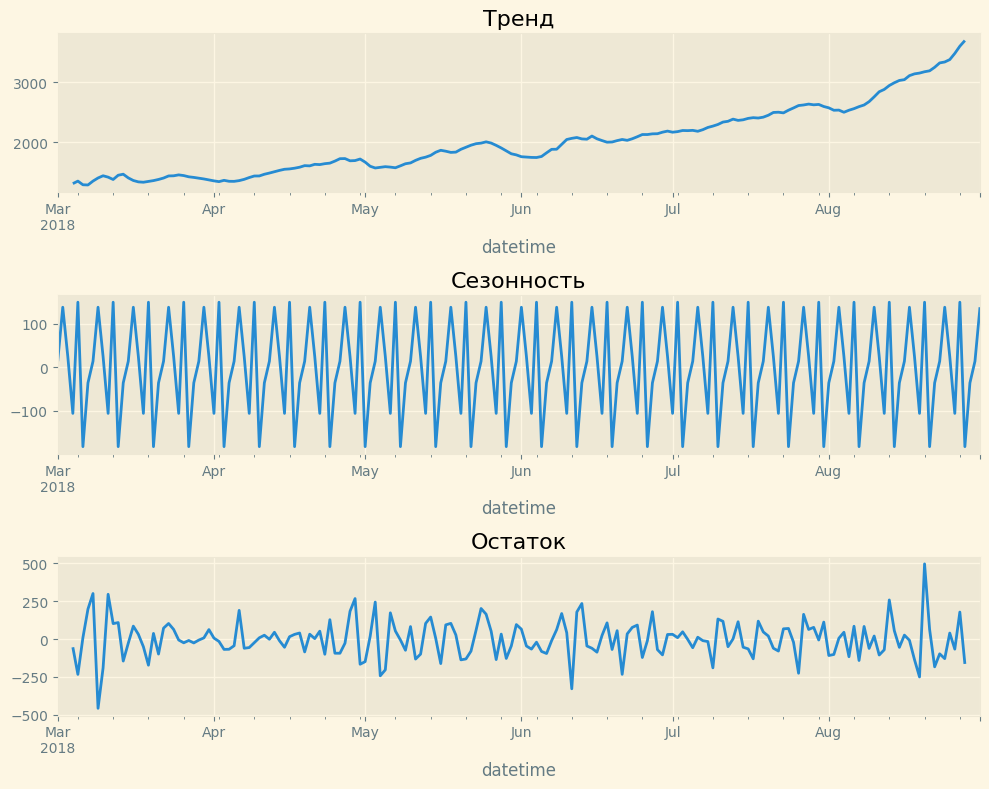

In [7]:
decomposed = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

По графику "Тренд" видна явная тенденция на увеличение колличества заказов. Поскольку у меня есть только отрезок данных в полгода, нельзя явно сказать, является ли это явление сезонным: для этого нам потребовались бы данные за несколько лет. Но на текущий момент можно предположить, что популярность сервиса в целом увеличивается.

График сезонности в таком масштабе не выглядит слишком информативным: воспользуюсь срезом за один август, чтобы увидеть, что на самом деле означает эта кардиограмма.

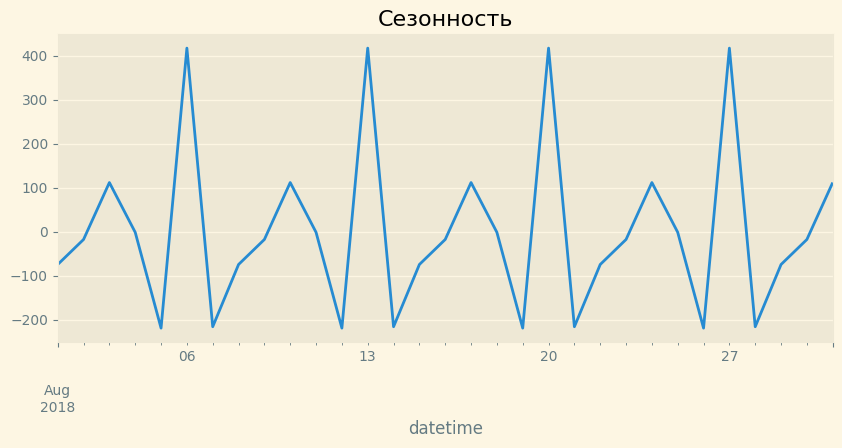

In [8]:
decomposed = seasonal_decompose(data.loc['2018-08'].resample('1D').sum())
decomposed.seasonal.plot(ax=plt.gca(), figsize=(10, 4))
plt.title('Сезонность')
plt.show()

Судя по отрезкам, данная тэнденция повтораяется каждую неделю: малый подъём в середине недели, затем спуск и резкий всплеск популяности в выходные. Т.е. по дню недели вполне можно предположить колличество заказов такси.

Выделю из даты отдельные столбцы: число, день недели и час. Месяц выделять не буду, т.к. всё-таки информации по месяцам слишком мало чтобы обучать на этом модель.

In [9]:
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data.head()

,num_orders,day,day_of_week,hour
datetime,,,,
2018-03-01 00:00:00,124,1,3,0
2018-03-01 01:00:00,85,1,3,1
2018-03-01 02:00:00,71,1,3,2
2018-03-01 03:00:00,66,1,3,3
2018-03-01 04:00:00,43,1,3,4


Я выделила число, день недели и час, теперь определю корреляцию между ними и колличеством заказов.

interval columns not set, guessing: ['num_orders', 'day', 'day_of_week', 'hour']


,num_orders,day,day_of_week,hour
num_orders,1.000000,0.179297,0.075726,0.560259
day,0.179297,1.000000,0.127801,0.000000
day_of_week,0.075726,0.127801,1.000000,0.000000
hour,0.560259,0.000000,0.000000,1.000000


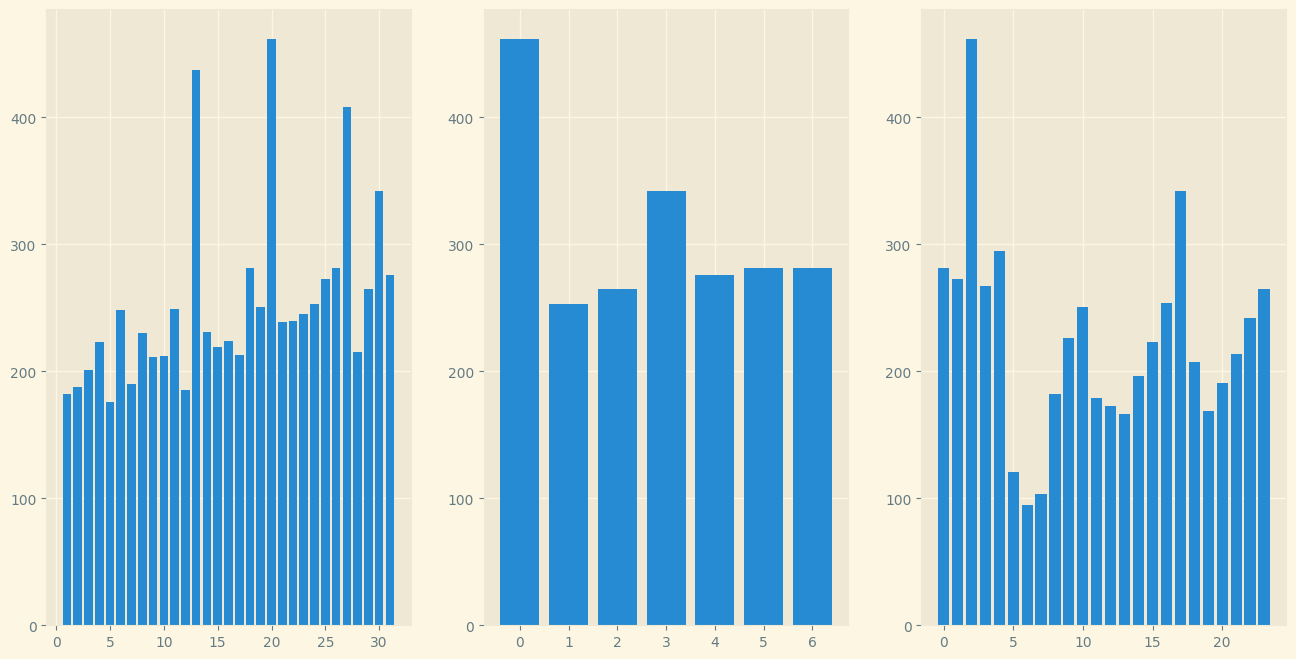

In [10]:
display(data.phik_matrix())
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].bar(data['day'], data['num_orders'])
axes[1].bar(data['day_of_week'], data['num_orders'])
axes[2].bar(data['hour'], data['num_orders'])
plt.show()

День недели и день месяца имеют слишком низкую корреляцию и могут оказать незативное влияние на результаты, так что удалю их из признаков.

In [11]:
data = data.drop('day', axis=1)
data = data.drop('day_of_week', axis=1)

Добавлю столбцы с отстающими значениями: на час, на 24 часа и на 168 часов (сколько вызовов было в тот же час неделю назад.)

In [12]:
data['lag_1'] = data['num_orders'].shift()
data['lag_24'] = data['num_orders'].shift(24)
data['lag_168'] = data['num_orders'].shift(168)
data = data.dropna()
data.head()

,num_orders,hour,lag_1,lag_24,lag_168
datetime,,,,,
2018-03-08 00:00:00,143,0,94.0,100.0,124.0
2018-03-08 01:00:00,78,1,143.0,121.0,85.0
2018-03-08 02:00:00,65,2,78.0,24.0,71.0
2018-03-08 03:00:00,68,3,65.0,66.0,66.0
2018-03-08 04:00:00,60,4,68.0,73.0,43.0


Добавлю столбец "rolling_mean". Он будет отражать скользящее среднее.

<Axes: xlabel='datetime'>

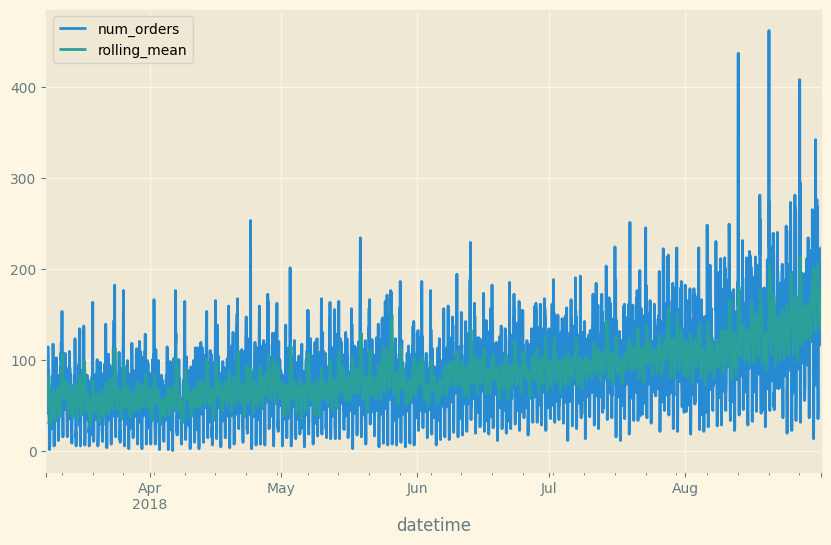

In [13]:
data['rolling_mean'] = data['num_orders'].shift().rolling(10).mean()
data = data.dropna()
data[['num_orders', 'rolling_mean']].plot(figsize=(10, 6))

### Промежуточный вывод

Доступна следующая временная информация: месяцы с марта по август, числа, дни недели и часы.

Месяц наверняка имеет высокую корреляцию с колличеством заказов, однако его использование может привести к тенденции моделей считать, что с увелечением месяца заказов обязательно становится больше, что может не соотноситься с реальностью: чтобы знать наверняка, нам нужны данные за несколько лет, а не за полгода.

Число оказывает малое влияние на количество заказов, и имеет слишком непостоянный график, потому мы не будем использовать его для обучения модели.

Час имеет самую высокую корреляцию: больше всего заказывают такси в 2 часа ночи (скорее всего, из-за неработающего общественного транспорта), меньше всего в 6 утра.

Таким образом, для обучения оставляем следующие признаки: день недели, час суток, отстающее значение на 1, 24 и 168 часов и скользящее среднее.

## Обучение

Разобью датасет на тренировочную, валидационную и тестовую выборки в соотношении 8:1:1.

In [14]:
train, test_valid = train_test_split(data, test_size=0.2, random_state=12345, shuffle=False)
valid, test = train_test_split(test_valid, test_size=0.5, random_state=12345, shuffle=False)
print('train.shape', train.shape)
print('valid.shape', valid.shape)
print('test.shape', test.shape)

train.shape (3390, 6)
valid.shape (424, 6)
test.shape (424, 6)


Выделяю признаки и целевой признак.

In [15]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
print('features_train.shape', features_train.shape, 'target_train.shape', target_train.shape)
print('features_valid.shape', features_valid.shape, 'target_valid.shape', target_valid.shape)
print('features_test.shape', features_test.shape, 'target_test.shape', target_test.shape)

features_train.shape (3390, 5) target_train.shape (3390,)
features_valid.shape (424, 5) target_valid.shape (424,)
features_test.shape (424, 5) target_test.shape (424,)


### Решающее дерево

Обучу обыкновенное решающее дерево с перебором максимальной глубины.

In [16]:
best_model_tree = None
best_depth = 0
best_rmse = 10000
for depth in range(1, 10):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    rmse = np.sqrt(mse(target_valid, pred))
    if rmse < best_rmse:
        best_model_tree = model
        best_depth = depth
        best_rmse = rmse
print('Лучшаяя модель решающего дерева показала RMSE', best_rmse, 'при глубине', best_depth)

Лучшаяя модель решающего дерева показала RMSE 33.59987147386967 при глубине 5


Запомним это RMSE и перейдём к следующей модели.

### Случайный лес

Обучу случайный лес — беггинг из решающих деревьев.

In [17]:
best_model_forest = None
best_depth = 0
best_est = 0
best_rmse = 10000
for est in range(10, 101, 5):
    for depth in range(1, 10):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        pred = model.predict(features_valid)
        rmse = np.sqrt(mse(target_valid, pred))
        if rmse < best_rmse:
            best_model_forest = model
            best_depth = depth
            best_est = est
            best_rmse = rmse
print('Лучшаяя модель случайного леса показала RMSE', best_rmse,
      'при глубине', best_depth, 'и колличестве деревьев', best_est)

Лучшаяя модель случайного леса показала RMSE 31.522335061703846 при глубине 7 и колличестве деревьев 100


Лес дал результат лучше простого дерева. Лучшую модель и RMSE запоминаем и двигаемся дальше.

### Градиентный бустинг

Бустинг я возьму на решающих деревьях из библиотеки LightGBM.

In [18]:
best_model_lgbm = None
best_depth = 0
best_est = 0
best_rmse = 10000
for est in range(10, 101, 5):
    for depth in range(1, 10):
        model = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        pred = model.predict(features_valid)
        rmse = np.sqrt(mse(target_valid, pred))
        if rmse < best_rmse:
            best_model_lgbm = model
            best_depth = depth
            best_est = est
            best_rmse = rmse
print('Лучшаяя модель LightGBM показала RMSE', best_rmse,
      'при глубине', best_depth, 'и колличестве деревьев', best_est)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 5
[LightGBM] [Info] Start training from score 75.635693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 5
[LightGBM] [Info] Start training from score 75.635693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 5
[LightGBM] [Info] Start training f

Здесь результат стал ещё лучше, чем был у случайного леса.

### Линейная регрессия

Построю линейную регрессию и посмотрю, как она себя покажет в сравнении с результатами древесных моделей.

In [19]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)
pred = model_linear.predict(features_valid)
rmse = np.sqrt(mse(target_valid, pred))
print('Модель линейной регрессии показала RMSE', rmse)

Модель линейной регрессии показала RMSE 31.515221324242763


Пускай под минимальные требования по заданию линейная регрессия проходит, её результат всё ещё хуже, чем у древесных моделей.

### Промежуточный вывод

Все модели показали приемлемый результат, но самый низкий показатель RMSE всё же был у бустинга.

## Тестирование

Проверю выбранную на этапе обучения модель (градиентный бустинг) на тестовой выборке и затем сравню результат с подстановкой предыдущего значения.

In [20]:
pred_test = best_model_lgbm.predict(features_test)
rmse_test = np.sqrt(mse(target_test, pred_test))
print('RMSE градиентного бустинга LightGBM на тестовой выборке равно', rmse_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE градиентного бустинга LightGBM на тестовой выборке равно 44.93906539530377


Обучу константную модель и сравню результаты.

In [21]:
pred_prev = target_test.shift()
pred_prev.iloc[0] = target_valid.iloc[-1]
rmse_prev = np.sqrt(mse(target_test, pred_prev))
print('Предсказание предыдущим значением ряда показывает RMSE', rmse_prev, 'Это больше RMSE LightGBM на', rmse_prev - rmse_test)

Предсказание предыдущим значением ряда показывает RMSE 58.88742457931834 Это больше RMSE LightGBM на 13.94835918401457


В таком масштабе, результат работы градиентного бустинга определённо выглядит неплохо. Я улучшила метрику RMSE на 11 относительно подставления предыдущего значения.

## Вывод

В данном проекте по машинному обучению задачей было обучить модель, предсказывающую колличество заказов такси от аэропорта в следующий час. Для этого были выполнены следующие работы:
- Загружен датасет и ресемплирован по одному часу;
- Проанализированы тренды и сезонность;
- Выделены выборки, их признаки и целевой признак;
- Обучены и сравнены между собой по метрике RMSE четыре модели;
- Выбрана лучшая модель и проверена на тестовой выборке с сравнением с подстановкой предыдущего значения.

Таким образом, была выбрана модель градиентного бустинга из библиотеки LightGBM, как обладающая наименьшим значением средней ошибки.